Задача: Разработать модель предсказания в каждом регионе объема продаж в штуках любого, выбранного вами, вида банки напитка Coca Cola.  Модель должна предсказывать объем продаж на каждый час следующих суток (от последней даты транзакции в датасете).
 
Описание полей в датасете: 

Фича             | Значение  
---------------- | -------------
***item_id***    | Id транзакции  
***receipt_id*** | Id чека  
***device_id***  | Id кассового аппарата  
***local_date*** | Дата и время покупки  
***barcode***    | Штрихкод  
***price***      | Цена покупки, рубли  
***quantity***   | Количество купленного товара, шт.  
***region***     | Регион  


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from typing import TypeVar
from pylab import rcParams
import itertools
import warnings

warnings.filterwarnings('ignore')
PandasDataFrame = TypeVar('pandas.core.frame.DataFrame')
PandasSeries = TypeVar('pandas.core.series.Series')
sns.set(rc = {'figure.figsize':(15,8)})
sns.set_theme(style="darkgrid")

#Функция для обращения отрицательных прогнозов в 0
def positiv(x: int) -> int:
    if x < 0:
        return 0
    else:
        return x


#Функция для обособления данных об одном регионе в отдельный фрейм и объединения всех покупок в данном регионе по часам
def get_region_data(data: PandasDataFrame, region: str) -> PandasDataFrame:
    data = data[data['region'] == region]
    data = data.drop(['region'], axis = 1)
    data = data.resample('1H').sum()
    
    g = sns.lineplot(data = data);
    
    return data


#Функция для проверки ряда на стационарность критерием Дики-Фуллера
def check_stationarity_series(data: PandasDataFrame)-> bool:
    test = sm.tsa.adfuller(data)
    
    if test[0]> test[4]['5%']: 
        print('Ряд не стационарен')
        return False
    else:
        print('Ряд стационарен')
        return True


#Функция которая фитит модель и отрисовывает предсказания, фит, и существующий временной ряд, также возвращает прогноз    
def fit_and_show_results(model, period: int,) -> PandasSeries:
    model_fit = model.fit()
    
    fc = model_fit.forecast(period, alpha=0.05)
    fc = fc.apply(round)
    fc = fc.apply(positiv)
    
    p = sns.lineplot(data = model_fit.predict(),color='g', label = 'Fitted quantity')
    p = sns.lineplot(data = fc, color='r', label = 'Predicted quantity')
    p = sns.lineplot(data = df_reg, color = 'b')
    p.set(xlabel = "Date", ylabel = 'Quantiti');
    
    return fc


В ходе рассмотрения задачи были попытки решить её экстраполяцией полиномами и рядами фурье, но данные подходы не показали достойный результат.  
Рассмотрим задачу как **прогнозирование временного ряда.** Недостатком такого подхода будет отсутствие "хороших" данных по воскресеньям, поэтому примем сезонность равной не 7 дням, а 24 часам.   
Так как необходимо предсказать покупки на ***следующие сутки***, то наибольшую ценность имеют ***последние данные в датасете***. Рассмотрим последнюю неделю данную в датасете. К сожалению, у нас нет наблюдений за воскресенье февраля, а в последнее январское воскресенье намного меньше измерений и их нельзя объеднять с февральскими данными, иначе мы получим искажённые предсказания.  Итак, рассмотрим февральские наблюдения. Так как в описании к датасету сказано, что количество выражено в ШТ - округлим значение данной фичи до целого, также удалим записи с отрицательным значения данного признака и с выбросами (используем для этого квантиль 99)


In [2]:
#читаем датасет и делаем индексацию по времени (оно уникально)
df = pd.read_csv(r'..\data\dataset.csv', index_col=['local_date'], parse_dates=['local_date'])

#штрих-код выбранного товара
df = df[df['barcode'] == '2000000000008']

df = df.drop(['Unnamed: 0',
              'item_id', 
              'receipt_id', 
              'device_id',
              'barcode',
              'price'],
               axis = 1)

df = df[(pd.DatetimeIndex(df.index).year == 2021) &
        (pd.DatetimeIndex(df.index).month == 2)]

df['quantity'] = df['quantity'].apply(round)
df = df[df['quantity'] > 0]
df = df[df['quantity'] <= df['quantity'].quantile(0.99)]
df = df.rename(columns={'quantity': 'Real quantity'})

#df_last_sunday_january = df[(pd.DatetimeIndex(df.index).month != 2) & 
#                           (pd.DatetimeIndex(df.index).day == 31)] 

df = df.sort_index()
df


,Real quantity,region
local_date,,
2021-02-01 00:19:36,1,Москва
2021-02-01 01:19:28,1,Москва
2021-02-01 02:08:47,4,Ямало-Ненецкий автономный округ
2021-02-01 03:53:11,1,Ямало-Ненецкий автономный округ
2021-02-01 05:05:43,1,Свердловская область
...,...,...
2021-02-06 23:39:05,1,Ярославская область
2021-02-06 23:44:01,3,Красноярский край
2021-02-06 23:46:54,1,Воронежская область


In [3]:
#Получим список регионов с продажами выбранного товара (список отсортирован по количеству продаж)
regions = list(df['region'].value_counts().index)
regions


['Оренбургская область',
 'Республика Башкортостан',
 'Кировская область',
 'Москва',
 'Тюменская область',
 'Ханты-Мансийский автономный округ',
 'Московская область',
 'Воронежская область',
 'Ростовская область',
 'Краснодарский край',
 'Алтайский край',
 'Иркутская область',
 'Приморский край',
 'Красноярский край',
 'Самарская область',
 'Нижегородская область',
 'Ямало-Ненецкий автономный округ',
 'Республика Марий Эл',
 'Республика Татарстан',
 'Липецкая область',
 'Ставропольский край',
 'Калининградская область',
 'Республика Коми',
 'Челябинская область',
 'Ярославская область',
 'Новосибирская область',
 'Республика Тыва',
 'Костромская область',
 'Белгородская область',
 'Санкт-Петербург',
 'Свердловская область',
 'Мурманская область',
 'Орловская область',
 'Республика Крым',
 'Рязанская область',
 'Вологодская область',
 'Саратовская область',
 'Ленинградская область',
 'Кемеровская область',
 'Курганская область',
 'Республика Хакасия',
 'Томская область',
 'Астраханска

'Республика Башкортостан'

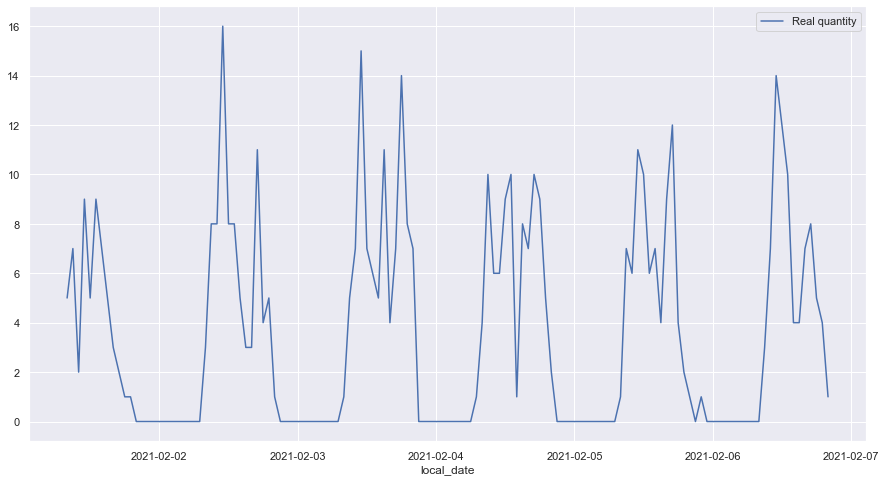

In [4]:
#индекс для региона принимает значения от 0 до 63
region_index = 1

df_reg = get_region_data(df, regions[region_index])
regions[region_index]


Ряд стационарен


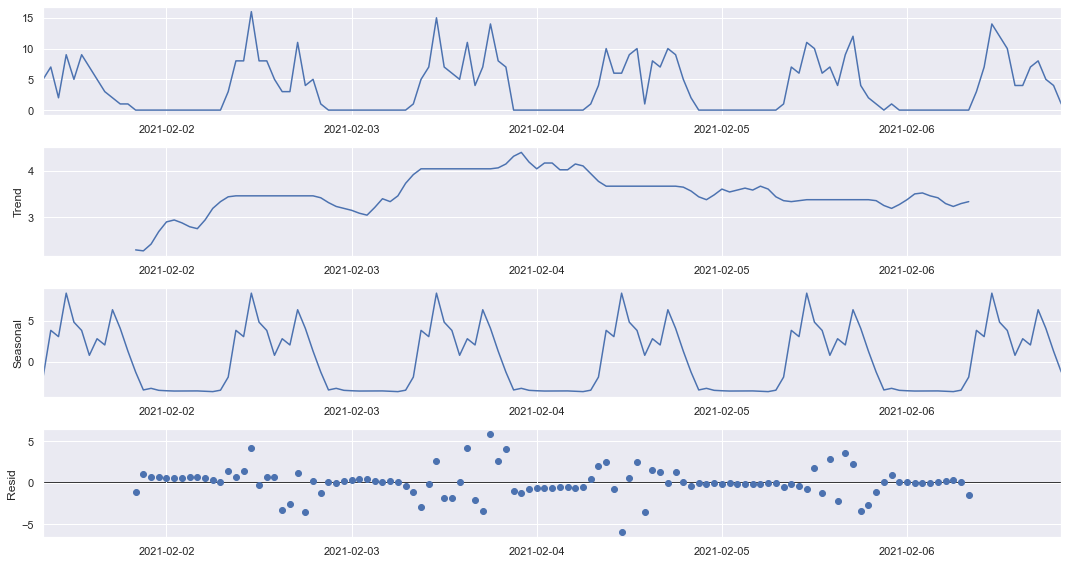

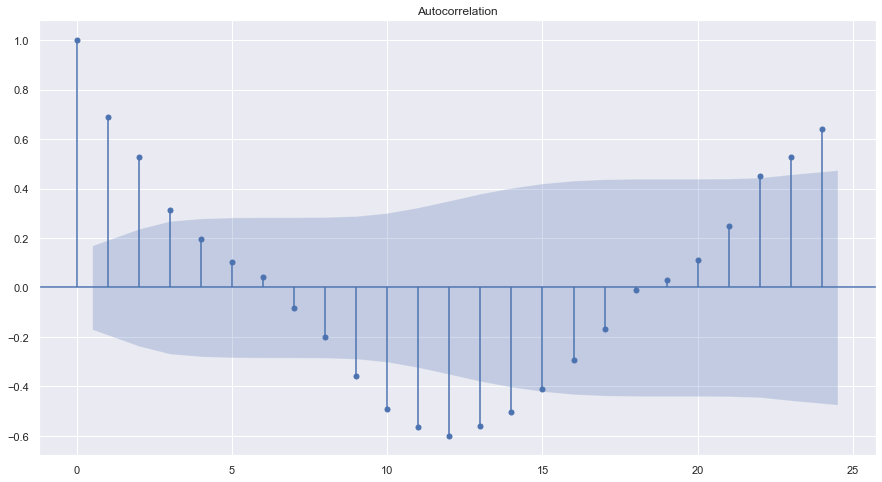

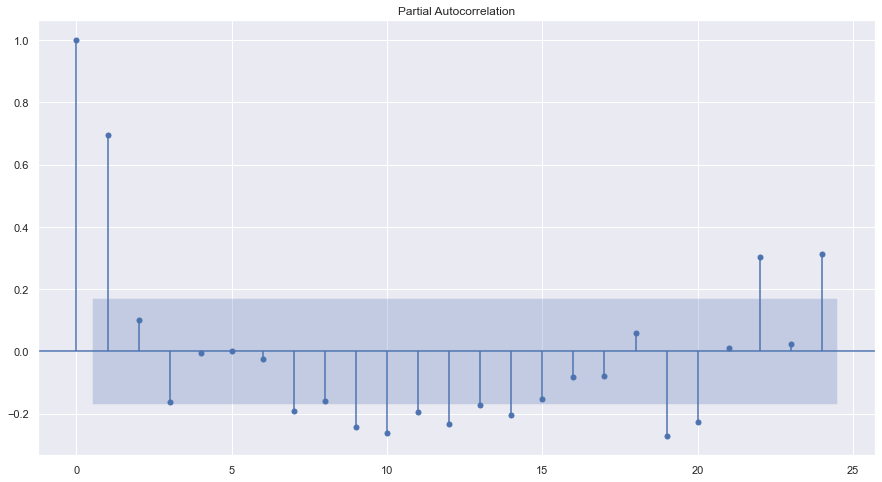

In [5]:
check_stationarity_series(df_reg)

decomposition = sm.tsa.seasonal_decompose(df_reg, model='additive')
fig = decomposition.plot()
sm.graphics.tsa.plot_acf(df_reg, lags=24)
sm.graphics.tsa.plot_pacf(df_reg, lags=24);


ARIMA(2, 1, 2) - AIC:655.0275464096148


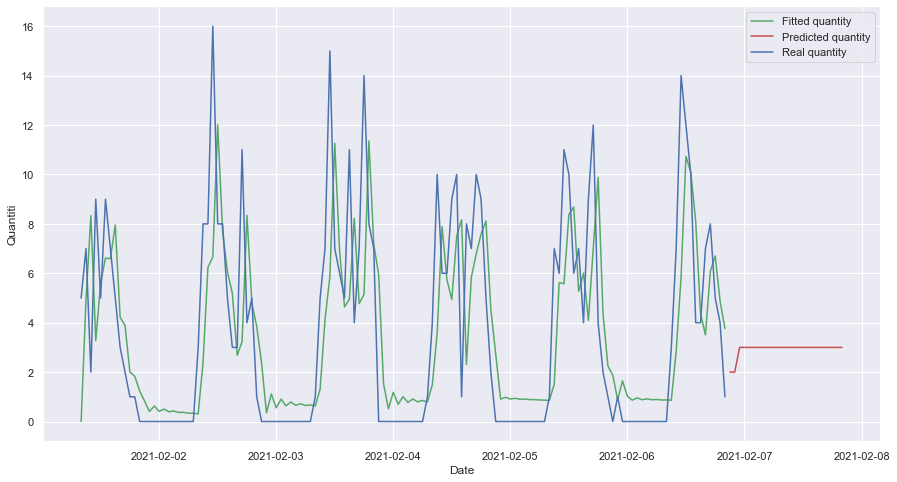

In [6]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

#По минимальному критерию Акаике построим модель arima
min_aic = 9999

for param in pdq:
    mod = ARIMA(df_reg,
                order=param,
                enforce_stationarity=False,
                enforce_invertibility=False)
    
    results = mod.fit()
    
    if results.aic < min_aic:
        min_aic = results.aic
        param_for_min_aic = param
        
print('ARIMA{} - AIC:{}'.format(param_for_min_aic, min_aic))        

model_ARIMA = ARIMA(df_reg, 
                    order=param_for_min_aic, 
                    enforce_stationarity=False,
                    enforce_invertibility=False) 

res_ARIMA = fit_and_show_results(model_ARIMA, 24)


ARIMA не видит сезонности, поэтому воспользуемся её модификацией SARIMA, данная модель должна учитывать сезонность

SARIMA(0, 1, 1)x(1, 1, 1, 24) - AIC:392.3985011555632


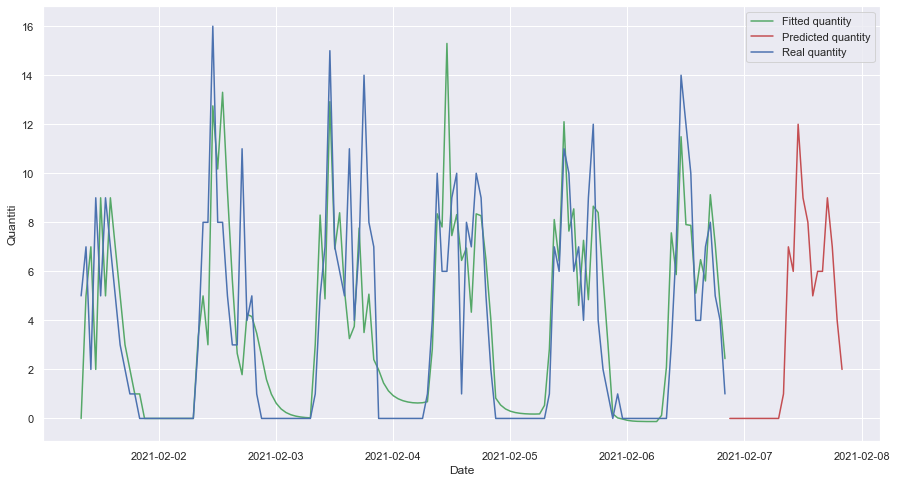

In [7]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]

#По минимальному критерию Акаике построим модель Sarima
min_aic = 9999

for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(df_reg,
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
        results = mod.fit()
        if results.aic < min_aic:
            min_aic = results.aic
            param_for_min_aic = param
            param_seasonal_for_min_aic = param_seasonal,results
            
print('SARIMA{}x{} - AIC:{}'.format(param_for_min_aic,
                                    param_seasonal_for_min_aic[0], 
                                    min_aic))
 
model_SARIMA = sm.tsa.statespace.SARIMAX(df_reg,
                                         order=param_for_min_aic,
                                         seasonal_order=param_seasonal_for_min_aic[0],
                                         enforce_stationarity=False,
                                         enforce_invertibility=False)

res_SARIMA = fit_and_show_results(model_SARIMA, 24)


In [8]:
print(regions[region_index])
res_SARIMA


Республика Башкортостан


2021-02-06 21:00:00     0
2021-02-06 22:00:00     0
2021-02-06 23:00:00     0
2021-02-07 00:00:00     0
2021-02-07 01:00:00     0
2021-02-07 02:00:00     0
2021-02-07 03:00:00     0
2021-02-07 04:00:00     0
2021-02-07 05:00:00     0
2021-02-07 06:00:00     0
2021-02-07 07:00:00     0
2021-02-07 08:00:00     1
2021-02-07 09:00:00     7
2021-02-07 10:00:00     6
2021-02-07 11:00:00    12
2021-02-07 12:00:00     9
2021-02-07 13:00:00     8
2021-02-07 14:00:00     5
2021-02-07 15:00:00     6
2021-02-07 16:00:00     6
2021-02-07 17:00:00     9
2021-02-07 18:00:00     7
2021-02-07 19:00:00     4
2021-02-07 20:00:00     2
Freq: H, Name: predicted_mean, dtype: int64